In [26]:
!pip install pycaret[full]

zsh:1: no matches found: pycaret[full]


In [87]:
import numpy as np
import pandas as pd

from pycaret.regression import *
from pycaret.utils import *
from sklearn.metrics import mean_squared_error
import datetime

In [101]:
dataset = pd.read_csv('datasets/big-table-train.csv')
dataset = dataset.dropna()
dataset = dataset.drop(columns=['completed_time', 'node_start', 'node_finish', 'lon_start', 'lon_end', 'lat_end', 'lat_start', 'average_speed'])

dataset

,Id,running_time,route_distance_km,delta_time,distance,speed,is_work_hour,is_night_time,is_late_night_time,is_rush_hour,humidity,visibility,windspeedKmph,tempC
0,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,31.771489,30.0,1,0,0,1,87,10,18,-4
3,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,50.034390,29.0,1,0,0,1,87,10,18,-4
4,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,13.453126,30.0,1,0,0,1,87,10,18,-4
5,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,15.994386,32.0,1,0,0,1,87,10,18,-4
7,-4773019581999572651,2022-01-24 18:30:21,3.740,862.0,47.897295,30.0,1,0,0,1,87,10,18,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401289,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,4.477717,42.0,0,0,1,0,85,10,23,-5
401290,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,28.463251,42.0,0,0,1,0,85,10,23,-5
401291,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,31.753756,30.0,0,0,1,0,85,10,23,-5
401294,-6353816735923374488,2022-01-24 00:35:03,6.452,552.0,59.467195,41.0,0,0,1,0,85,10,23,-5


In [106]:
dataset_agg = dataset.groupby(['Id', 'running_time', 'route_distance_km', 'delta_time'])\
    .agg({'distance': ['min', 'max', 'mean', 'std'], 'speed': ['min', 'max', 'mean', 'std']}).reset_index()

dataset_agg = dataset_agg.drop(columns=['Id'])
dataset_agg['running_time'] = (pd.to_datetime(dataset_agg['running_time']) - datetime.datetime(1970,1,1)).dt.total_seconds()
dataset_agg

running_time route_distance_km delta_time  distance              \
                                                      min         max   
0     1.643067e+09             3.179      469.0  2.494184  127.702093   
1     1.643058e+09             6.137      688.0  2.664808  176.030833   
2     1.643064e+09             6.312      683.0  1.261206  201.267382   
3     1.643063e+09             6.379      885.0  2.757002  231.663338   
4     1.643045e+09             2.551      612.0  1.735633  224.340608   
...            ...               ...        ...       ...         ...   
4990  1.643065e+09             5.520      753.0  1.306968  327.558417   
4991  1.643057e+09             3.146      462.0  1.688882  156.095828   
4992  1.643002e+09             4.038      607.0  4.213290  184.102066   
4993  1.643056e+09             1.641      223.0  1.306756   89.077514   
4994  1.643050e+09             2.489      368.0  8.476520  184.070599   

                           speed                              
           mean        std   min   max       mean        std  
0     33.761364  28.634283  11.0  43.0  25.342857   7.550575  
1     47.742523  42.632365  10.0  50.0  29.904110   8.487187  
2     33.584700  33.855656   7.0  47.0  33.028926   8.396502  
3     37.848757  38.958754  15.0  51.0  36.278846   9.887186  
4     31.892602  43.984874   9.0  83.0  24.270270  12.985025  
...         ...        ...   ...   ...        ...        ...  
4990  32.873786  46.691882  11.0  58.0  33.803704   9.062819  
4991  28.981445  30.362658  18.0  41.0  30.740964   6.662308  
4992  49.033223  41.811231  19.0  68.0  40.695652  10.822504  
4993  25.529379  20.015225  13.0  32.0  24.372093   4.556645  
4994  49.910280  46.718347  18.0  40.0  30.212121   5.128094  

[4995 rows x 11 columns]

In [107]:
dataset_agg = pd.DataFrame(dataset_agg.values, columns=['running_time', 'route_distance_km', 'delta_time', 'min_distance', 'max_distance', 'mean_distance', 'std_distance', 'min_speed', 'max_speed', 'mean_speed', 'std_speed'])
dataset_agg['delta_time'] = np.log1p(dataset_agg['delta_time'])
dataset_agg

,running_time,route_distance_km,delta_time,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed
0,1.643067e+09,3.179,6.152733,2.494184,127.702093,33.761364,28.634283,11.0,43.0,25.342857,7.550575
1,1.643058e+09,6.137,6.535241,2.664808,176.030833,47.742523,42.632365,10.0,50.0,29.904110,8.487187
2,1.643064e+09,6.312,6.527958,1.261206,201.267382,33.584700,33.855656,7.0,47.0,33.028926,8.396502
3,1.643063e+09,6.379,6.786717,2.757002,231.663338,37.848757,38.958754,15.0,51.0,36.278846,9.887186
4,1.643045e+09,2.551,6.418365,1.735633,224.340608,31.892602,43.984874,9.0,83.0,24.270270,12.985025
...,...,...,...,...,...,...,...,...,...,...,...
4990,1.643065e+09,5.520,6.625392,1.306968,327.558417,32.873786,46.691882,11.0,58.0,33.803704,9.062819
4991,1.643057e+09,3.146,6.137727,1.688882,156.095828,28.981445,30.362658,18.0,41.0,30.740964,6.662308
4992,1.643002e+09,4.038,6.410175,4.213290,184.102066,49.033223,41.811231,19.0,68.0,40.695652,10.822504
4993,1.643056e+09,1.641,5.411646,1.306756,89.077514,25.529379,20.015225,13.0,32.0,24.372093,4.556645


In [108]:
data = dataset_agg.sample(frac=0.9, random_state=786)
data_unseen = dataset_agg.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4496, 11)
Unseen Data For Predictions: (499, 11)


In [109]:
s = setup(data = data, target = 'delta_time', session_id=123, use_gpu=False, normalize = True)

,Description,Value
0,Session id,123
1,Target,delta_time
2,Target type,Regression
3,Original data shape,"(4496, 11)"
4,Transformed data shape,"(4496, 11)"
5,Transformed train set shape,"(3147, 11)"
6,Transformed test set shape,"(1349, 11)"
7,Numeric features,10
8,Rows with missing values,0.0%
9,Preprocess,True


In [10]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [11]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.1787,0.0605,0.2455,0.6217,0.0348,0.0289,0.1620
lightgbm,Light Gradient Boosting Machine,0.1821,0.0610,0.2468,0.6191,0.0349,0.0294,0.0540
et,Extra Trees Regressor,0.1824,0.0614,0.2475,0.6164,0.0350,0.0295,0.2340
rf,Random Forest Regressor,0.1816,0.0620,0.2487,0.6122,0.0352,0.0294,0.3780
lr,Linear Regression,0.2101,0.0781,0.2791,0.5140,0.0392,0.0339,0.4550
ridge,Ridge Regression,0.2101,0.0781,0.2791,0.5140,0.0392,0.0339,0.0170
lar,Least Angle Regression,0.2101,0.0781,0.2791,0.5140,0.0392,0.0339,0.0200
br,Bayesian Ridge,0.2102,0.0781,0.2791,0.5140,0.0392,0.0339,0.0190
huber,Huber Regressor,0.2085,0.0787,0.2801,0.5104,0.0393,0.0337,0.0210
knn,K Neighbors Regressor,0.2114,0.0792,0.2813,0.5068,0.0397,0.0343,0.0230


In [12]:
best_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1795,0.0585,0.2419,0.6732,0.0343,0.0291
1,0.1835,0.0663,0.2575,0.5283,0.0361,0.0294
2,0.1825,0.0666,0.2581,0.5628,0.0363,0.0294
3,0.1729,0.0598,0.2445,0.6225,0.0344,0.0279
4,0.1766,0.0580,0.2407,0.6662,0.0342,0.0287
5,0.1794,0.0558,0.2363,0.7084,0.0334,0.0291
6,0.1860,0.0588,0.2424,0.6352,0.0345,0.0301
7,0.1710,0.0565,0.2377,0.6396,0.0335,0.0277
8,0.1620,0.0476,0.2181,0.6682,0.0307,0.0261


In [13]:
tuned_best_model = tune_model(best_model, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1784,0.0576,0.2401,0.6781,0.0340,0.0289
1,0.1861,0.0645,0.2540,0.5411,0.0354,0.0298
2,0.1852,0.0728,0.2698,0.5220,0.0382,0.0299
3,0.1757,0.0602,0.2453,0.6200,0.0345,0.0283
4,0.1755,0.0560,0.2367,0.6773,0.0335,0.0285
5,0.1790,0.0562,0.2372,0.7063,0.0334,0.0290
6,0.1820,0.0584,0.2417,0.6373,0.0345,0.0296
7,0.1670,0.0517,0.2274,0.6701,0.0320,0.0270
8,0.1651,0.0488,0.2210,0.6593,0.0311,0.0266


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


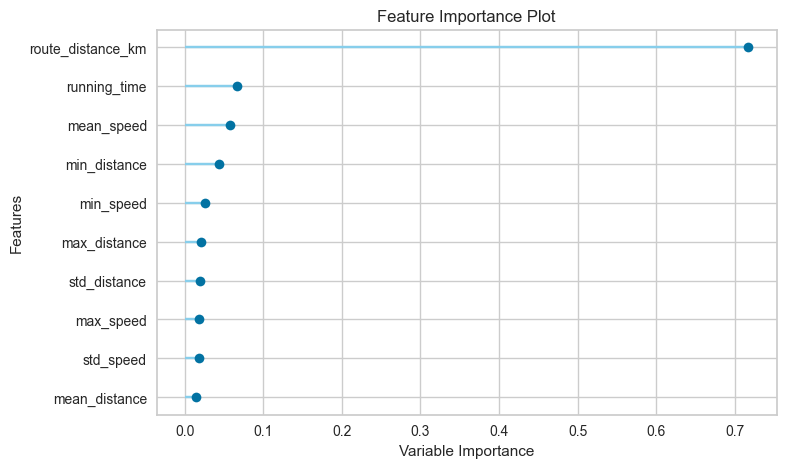

In [14]:
plot_model(tuned_best_model, 'feature')

In [25]:
interpret_model(tuned_best_model)

ModuleNotFoundError: 
'shap' is a soft dependency and not included in the pycaret installation. Please run: `pip install shap` to install.
Alternately, you can install this by running `pip install pycaret[analysis]`

In [110]:
# validate on unseen data
unseen_predictions = predict_model(tuned_best_model, data=data_unseen)
unseen_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.1576,0.0449,0.2120,0.6920,0.0297,0.0254


,running_time,route_distance_km,min_distance,max_distance,mean_distance,std_distance,min_speed,max_speed,mean_speed,std_speed,delta_time,prediction_label
0,1.643062e+09,1.722,6.701660,169.959030,49.144840,39.329720,28.0,50.0,42.285713,6.061311,5.446737,5.596940
1,1.643014e+09,4.547,1.114897,164.616898,36.166325,33.304737,18.0,48.0,31.510000,7.869510,6.646390,6.642124
2,1.643045e+09,3.328,1.820466,102.959122,37.501324,28.575573,7.0,31.0,25.181818,4.857048,6.658011,6.399642
3,1.643063e+09,7.871,1.078196,231.663300,32.680599,35.284466,12.0,49.0,33.848900,8.166464,6.845880,6.750474
4,1.642994e+09,2.501,2.641901,155.466187,39.811680,35.069832,27.0,46.0,34.105263,6.648672,5.780744,5.862309
...,...,...,...,...,...,...,...,...,...,...,...,...
494,1.643015e+09,5.371,1.786217,154.144867,43.244476,36.731350,18.0,61.0,42.586208,12.515303,6.510258,6.548110
495,1.643051e+09,3.427,5.170965,268.783508,47.590919,53.540043,10.0,44.0,28.972973,9.705343,5.860786,6.275231
496,1.643031e+09,3.094,1.968851,267.655762,44.794144,51.484505,6.0,48.0,28.666666,5.629927,6.395262,6.439717
497,1.643006e+09,7.662,0.757768,203.738800,35.549873,38.707394,15.0,62.0,38.915585,9.254536,6.792345,6.804748


In [111]:
(mean_squared_error(np.expm1(unseen_predictions['delta_time']), np.expm1(unseen_predictions['prediction_label']), squared=False))

114.80233553643195

### Model predictions on test data

In [112]:
big_table_test_df = pd.read_csv("datasets/big-table-test.csv")
big_table_test_df

,Id,running_time,route_distance_km,node_start,node_finish,distance,speed,average_speed,lon_start,lat_start,lon_end,lat_end,is_work_hour,is_night_time,is_late_night_time,is_rush_hour,humidity,visibility,windspeedKmph,tempC
0,6198,2022-01-24 03:38:30,4.744,8952394129,8952394128,138.795710,37.0,47.573034,NaN,NaN,NaN,NaN,0,0,1,0,84,10,24,-5
1,6198,2022-01-24 03:38:30,4.744,2059503754,4548172320,95.273001,33.0,47.573034,30.724095,46.431127,30.724951,46.431748,0,0,1,0,84,10,24,-5
2,6198,2022-01-24 03:38:30,4.744,2059504508,2059503754,137.647881,35.0,47.573034,30.722883,46.430222,30.724095,46.431127,0,0,1,0,84,10,24,-5
3,6198,2022-01-24 03:38:30,4.744,1570776534,1977018578,4.383708,30.0,47.573034,NaN,NaN,NaN,NaN,0,0,1,0,84,10,24,-5
4,6198,2022-01-24 03:38:30,4.744,1977018580,1977018576,24.195593,31.0,47.573034,30.725686,46.437680,30.725999,46.437652,0,0,1,0,84,10,24,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102537,527850,2022-01-24 18:45:20,10.127,290891780,5957304897,40.933260,45.0,48.289474,30.735412,46.470630,30.735943,46.470589,1,0,0,1,87,10,18,-4
102538,527850,2022-01-24 18:45:20,10.127,5957304897,3902949792,63.421598,34.0,48.289474,30.735943,46.470589,30.736766,46.470527,1,0,0,1,87,10,18,-4
102539,527850,2022-01-24 18:45:20,10.127,3902949792,290404192,4.303810,16.0,48.289474,30.736766,46.470527,30.736851,46.470520,1,0,0,1,87,10,18,-4
102540,527850,2022-01-24 18:45:20,10.127,290404192,5957304888,5.250640,37.0,48.289474,30.736851,46.470520,30.736845,46.470473,1,0,0,1,87,10,18,-4


In [113]:
prediction_agg = big_table_test_df.groupby(['Id', 'running_time', 'route_distance_km']) \
    .agg({'distance': ['min', 'max', 'mean', 'std'], 'speed': ['min', 'max', 'mean', 'std']}).reset_index()

prediction_agg = prediction_agg.drop(columns=['Id'])
prediction_agg['running_time'] = (pd.to_datetime(prediction_agg['running_time']) - datetime.datetime(1970,1,1)).dt.total_seconds()
prediction_agg = pd.DataFrame(dataset_agg.values, columns=['running_time', 'route_distance_km', 'min_distance', 'max_distance', 'mean_distance', 'std_distance', 'min_speed', 'max_speed', 'mean_speed', 'std_speed'])

ValueError: Shape of passed values is (4995, 11), indices imply (4995, 10)

In [114]:
data_prediction = prediction_agg
data_prediction.reset_index(drop=True, inplace=True)

In [115]:
submission_df = pd.read_csv("datasets/submission.csv")
submission_df

,Id,Predicted
0,6198,0
1,6417,0
2,7054,0
3,9628,0
4,10283,0
...,...,...
995,525706,0
996,526604,0
997,527213,0
998,527520,0


In [116]:
submission_predictions = predict_model(tuned_best_model, data=data_prediction)
submission_predictions

KeyError: "['min_distance' 'max_distance' 'mean_distance' 'std_distance' 'min_speed'\n 'max_speed' 'mean_speed' 'std_speed'] not in index"

In [100]:
predicted_df = submission_predictions[['Id', "prediction_label"]].drop_duplicates(subset=["Id"], keep='first')
predicted_df

,running_time,prediction_label
0,1.643067e+09,6.222833
1,1.643058e+09,6.703499
2,1.643064e+09,6.717895
3,1.643063e+09,6.704921
4,1.643045e+09,6.347178
...,...,...
4532,1.643039e+09,5.947388
4537,1.642992e+09,6.329001
4550,1.642990e+09,6.675958
4722,1.642994e+09,6.677404


In [ ]:
submission_df = submission_df \
    .merge(predicted_df, on='Id', how='inner') \
    .drop_duplicates(subset=["Id"], keep='first')
submission_df

In [32]:
submission_df["Predicted"] = submission_df["prediction_label"]
submission_df.drop("prediction_label", axis=1, inplace=True)

KeyError: 'prediction_label'

In [ ]:
submission_df.to_csv("datasets/submission.csv", index=False)

## Submission phase

Guide: https://www.kaggle.com/code/derrickmwiti/how-to-make-submissions-using-kaggle-s-api/notebook

In [ ]:
!pip install kaggle

In [ ]:
import os
os.environ["KAGGLE_USERNAME"]="beardimon"
os.environ["KAGGLE_KEY"]="22adc3776f244a54f4732bf8dfb077eb"

In [ ]:
!kaggle competitions submit -c int20h-2023-hackathon  -f ./datasets/submission.csv -m "Baseline"

In [ ]:
!kaggle competitions leaderboard -c int20h-2023-hackathon --show

In [ ]:
!kaggle competitions submissions -c int20h-2023-hackathon